In [2]:
# !pip install shap

In [3]:
# !pip install seaborn

In [1]:
# !pip install -U imbalanced-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import joblib

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import shap

sns.set_style('white')
sns.set_palette('Set2')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# from google.colab import drive
# # drive.mount('/content/drive')

In [3]:
save_path = 'DM_models/'

# Get the Data

In [4]:
# train data
train_ds = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')

# test data
test_ds = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [5]:
print(f"train shape: {train_ds.shape}")
print(f"test shape: {test_ds.shape}")

train shape: (253680, 22)
test shape: (70692, 22)


In [6]:
print(train_ds.dtypes)


Diabetes_binary         float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object


In [7]:
train_ds.isnull().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

# EDA

In [8]:
train_ds.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [9]:
[print(f"{i}) {col} => {np.sort(train_ds[col].unique())}\n") for i, col in enumerate(train_ds.columns)]


0) Diabetes_binary => [0. 1.]

1) HighBP => [0. 1.]

2) HighChol => [0. 1.]

3) CholCheck => [0. 1.]

4) BMI => [12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.
 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.
 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83.
 84. 85. 86. 87. 88. 89. 90. 91. 92. 95. 96. 98.]

5) Smoker => [0. 1.]

6) Stroke => [0. 1.]

7) HeartDiseaseorAttack => [0. 1.]

8) PhysActivity => [0. 1.]

9) Fruits => [0. 1.]

10) Veggies => [0. 1.]

11) HvyAlcoholConsump => [0. 1.]

12) AnyHealthcare => [0. 1.]

13) NoDocbcCost => [0. 1.]

14) GenHlth => [1. 2. 3. 4. 5.]

15) MentHlth => [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]

16) PhysHlth => [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

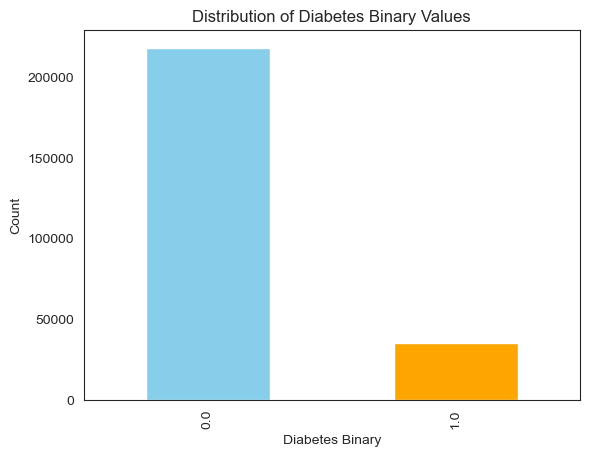

In [10]:
counts = train_ds['Diabetes_binary'].value_counts()

# Plotting the bar chart
counts.plot(kind='bar', color=['skyblue', 'orange'])

# Adding labels and title
plt.xlabel('Diabetes Binary')
plt.ylabel('Count')
plt.title('Distribution of Diabetes Binary Values')

# Display the plot
plt.show()


#### Dataset imbalanced

#### using SMOTE

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification


## Categorical variables

In [26]:
# Demographics
demographics = ['Age', 'Sex', 'Education', 'Income']

# Healthcare Access
healthcare_access = ['AnyHealthcare', 'NoDocbcCost']

# Cardiovascular Health
cardiovascular_health = ['HighBP', 'HighChol', 'CholCheck', 'Stroke', 'HeartDiseaseorAttack']

# Physical Health
physical_health = ['DiffWalk', 'GenHlth', 'MentHlth', 'PhysHlth']

# Lifestyle Habits
lifestyle_habits = ['PhysActivity', 'Smoker', 'Fruits', 'Veggies', 'HvyAlcoholConsump']

# Overall Health and Habits
overall_health_habits = cardiovascular_health + physical_health + lifestyle_habits

# Printing the categories
print("Demographics:", demographics)
print("Healthcare Access:", healthcare_access)
print("Cardiovascular Health:", cardiovascular_health)
print("Physical Health:", physical_health)
print("Lifestyle Habits:", lifestyle_habits)
print("Overall Health and Habits:", overall_health_habits)


Demographics: ['Age', 'Sex', 'Education', 'Income']
Healthcare Access: ['AnyHealthcare', 'NoDocbcCost']
Cardiovascular Health: ['HighBP', 'HighChol', 'CholCheck', 'Stroke', 'HeartDiseaseorAttack']
Physical Health: ['DiffWalk', 'GenHlth', 'MentHlth', 'PhysHlth']
Lifestyle Habits: ['PhysActivity', 'Smoker', 'Fruits', 'Veggies', 'HvyAlcoholConsump']
Overall Health and Habits: ['HighBP', 'HighChol', 'CholCheck', 'Stroke', 'HeartDiseaseorAttack', 'DiffWalk', 'GenHlth', 'MentHlth', 'PhysHlth', 'PhysActivity', 'Smoker', 'Fruits', 'Veggies', 'HvyAlcoholConsump']




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



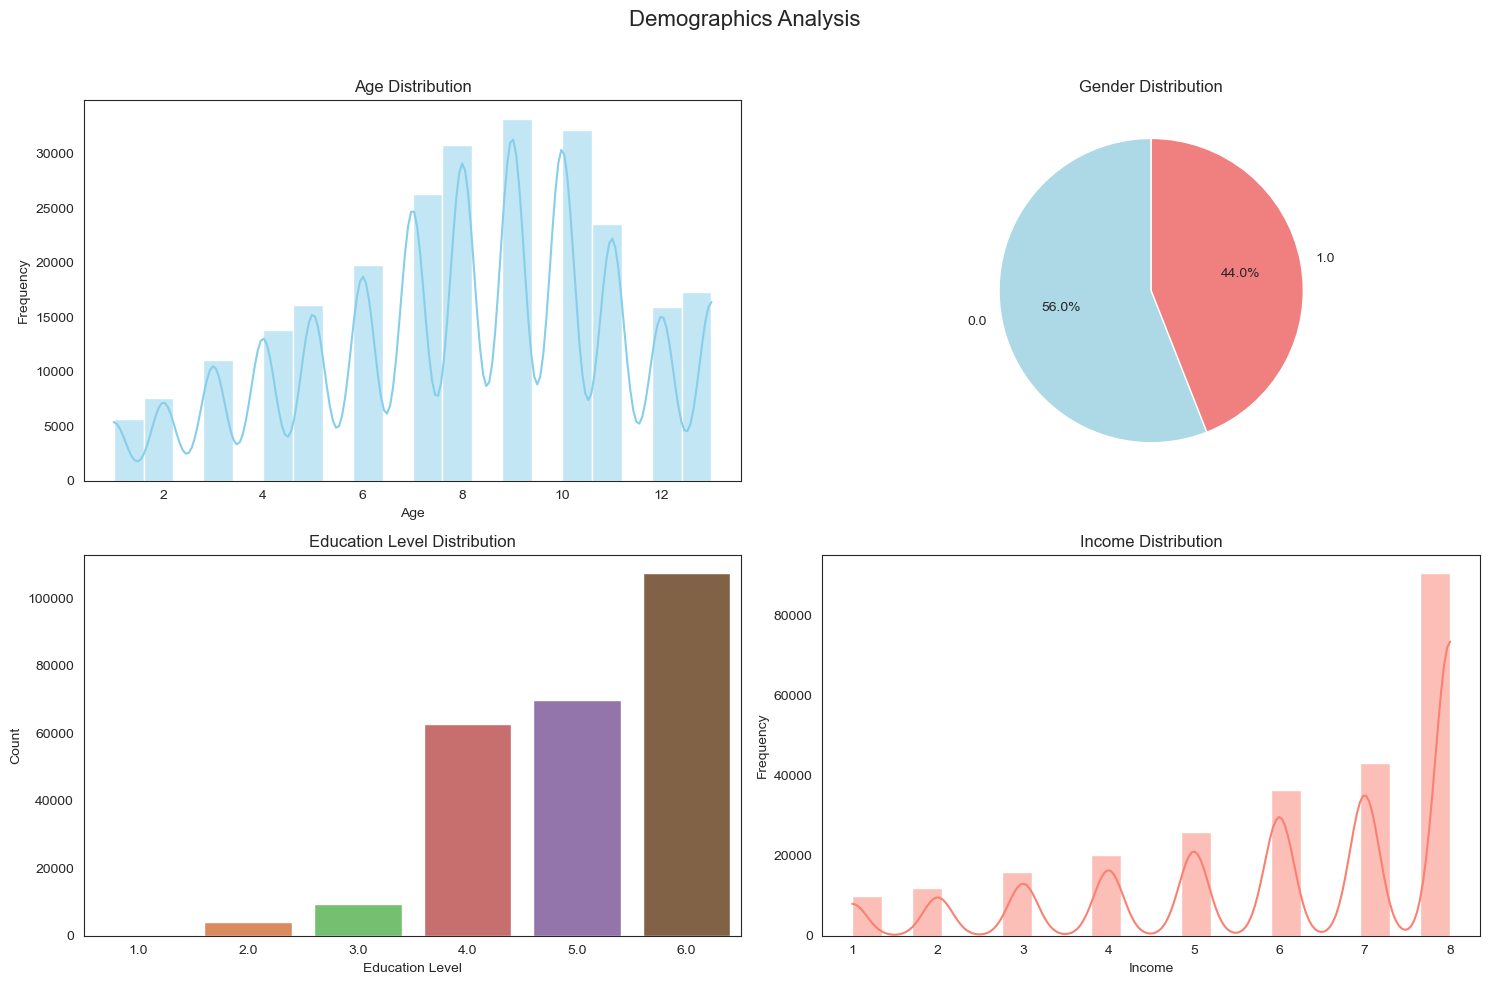

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'train_ds' is your DataFrame containing the demographics data

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Demographics Analysis', fontsize=16)

# Age Distribution
sns.histplot(train_ds['Age'], bins=20, kde=True, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')

# Gender Distribution Pie Chart
gender_counts = train_ds['Sex'].value_counts()
labels = gender_counts.index
colors = ['lightblue', 'lightcoral']
axes[0, 1].pie(gender_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Gender Distribution')

# Education Level Distribution
sns.countplot(x='Education', data=train_ds, palette='muted', ax=axes[1, 0])
axes[1, 0].set_title('Education Level Distribution')
axes[1, 0].set_xlabel('Education Level')
axes[1, 0].set_ylabel('Count')

# Income Distribution
sns.histplot(train_ds['Income'], bins=20, kde=True, color='salmon', ax=axes[1, 1])
axes[1, 1].set_title('Income Distribution')
axes[1, 1].set_xlabel('Income')
axes[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


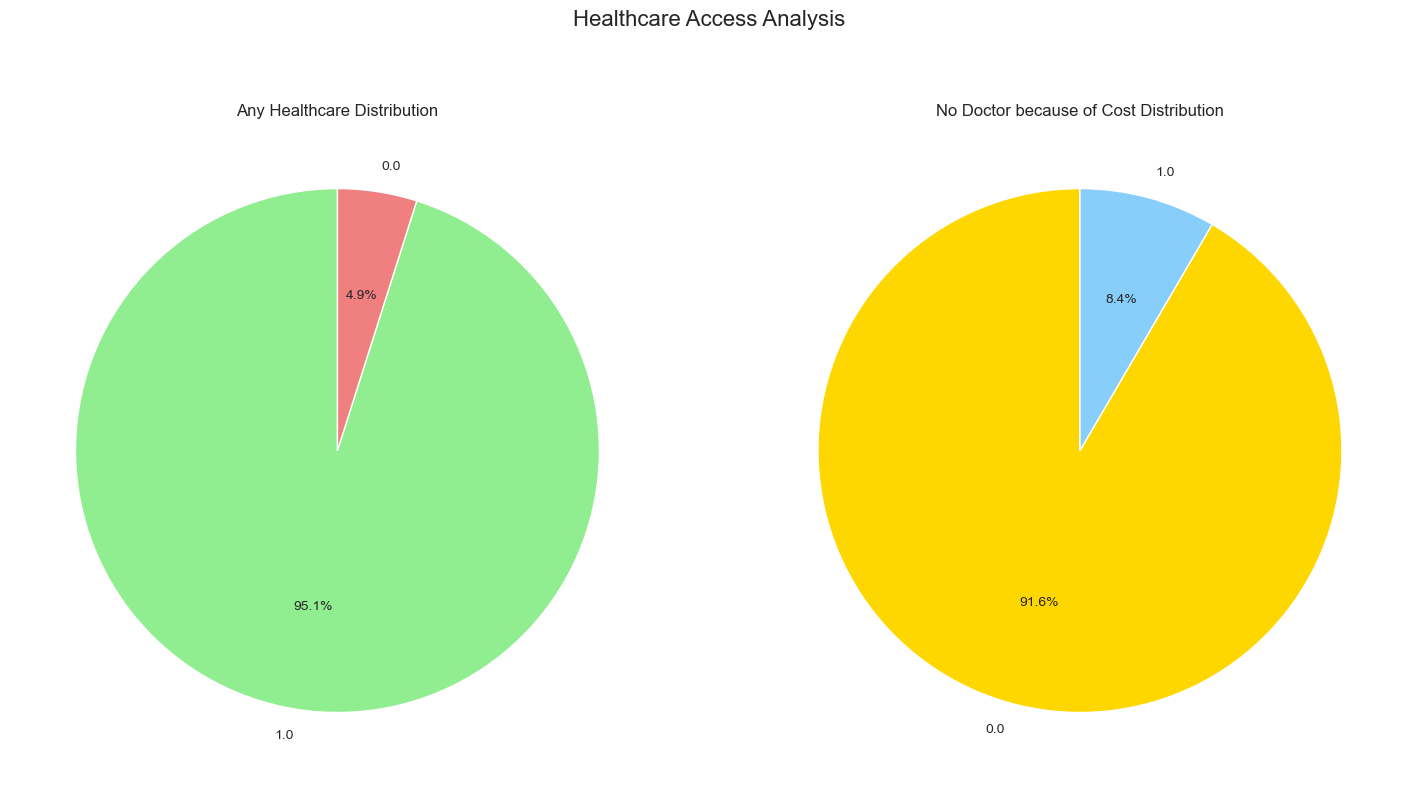

In [28]:
import matplotlib.pyplot as plt

# Assuming 'train_ds' is your DataFrame

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle('Healthcare Access Analysis', fontsize=16)

# Any Healthcare Distribution Pie Chart
healthcare_counts = train_ds['AnyHealthcare'].value_counts()
labels_healthcare = healthcare_counts.index
colors_healthcare = ['lightgreen', 'lightcoral']

axes[0].pie(healthcare_counts, labels=labels_healthcare, colors=colors_healthcare, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Any Healthcare Distribution')

# No Doctor because of Cost Distribution Pie Chart
doc_cost_counts = train_ds['NoDocbcCost'].value_counts()
labels_doc_cost = doc_cost_counts.index
colors_doc_cost = ['gold', 'lightskyblue']

axes[1].pie(doc_cost_counts, labels=labels_doc_cost, colors=colors_doc_cost, autopct='%1.1f%%', startangle=90)
axes[1].set_title('No Doctor because of Cost Distribution')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



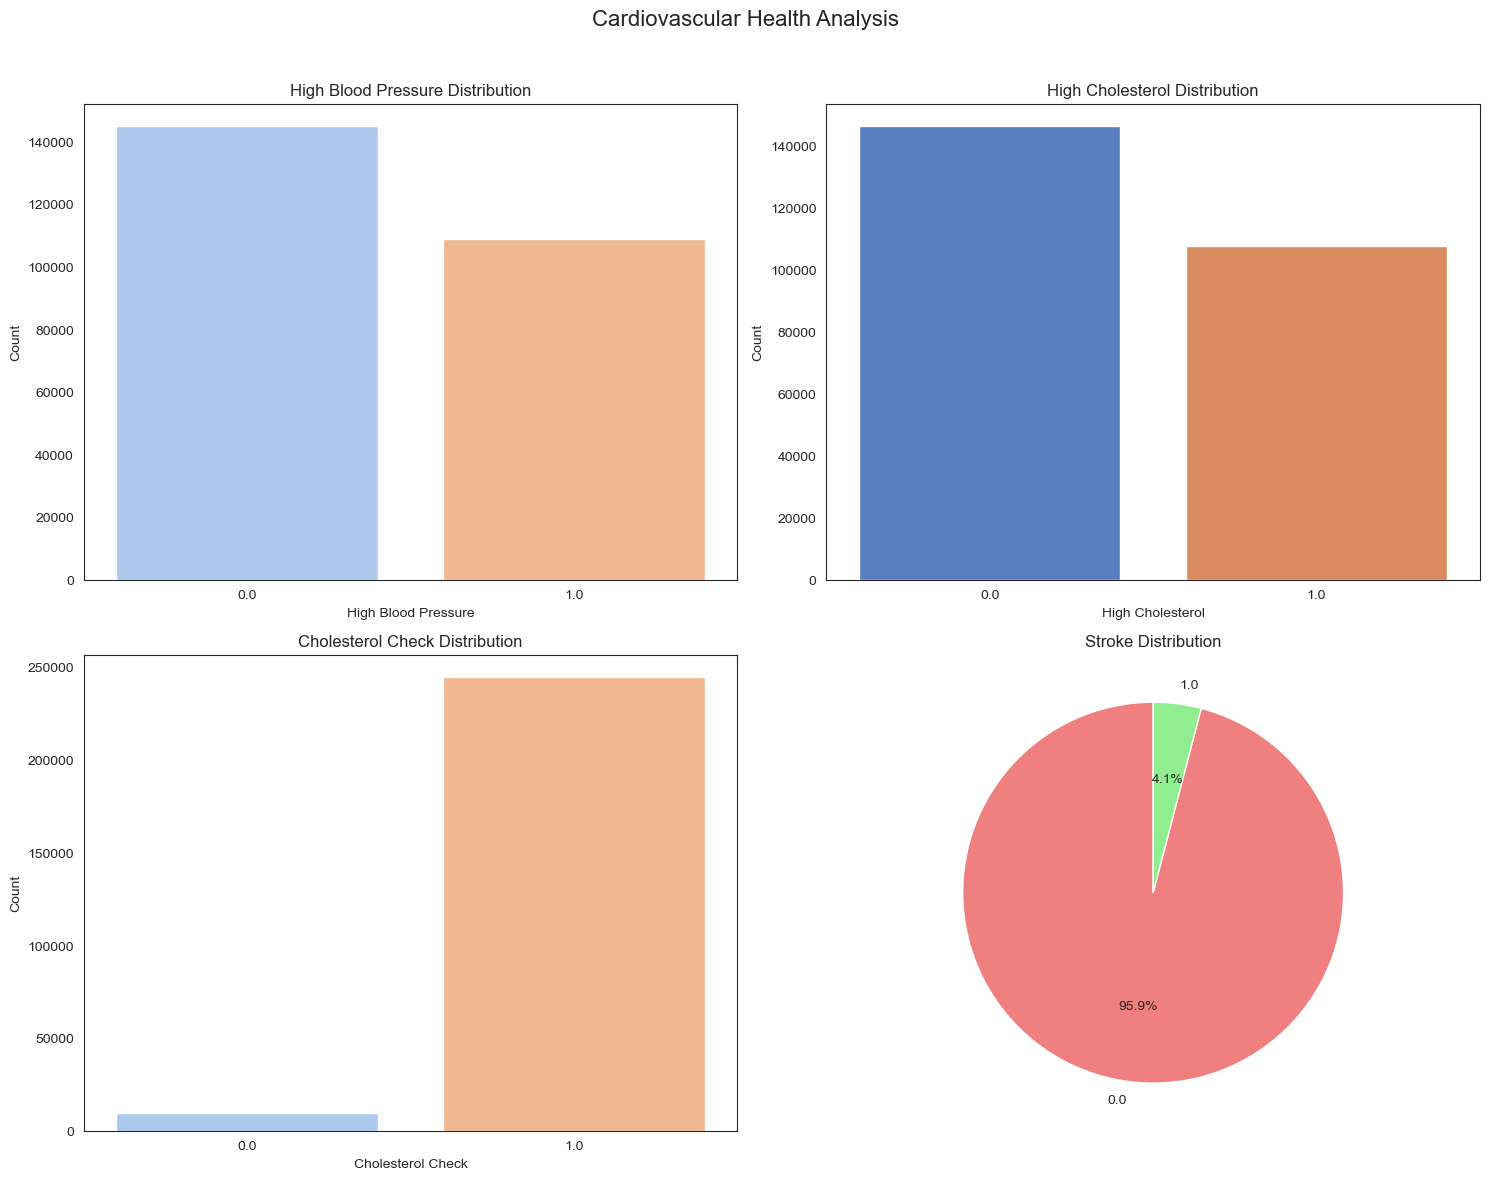

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'train_ds' is your DataFrame

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Cardiovascular Health Analysis', fontsize=16)

# High Blood Pressure (HighBP) Distribution
sns.countplot(x='HighBP', data=train_ds, palette='pastel', ax=axes[0, 0])
axes[0, 0].set_title('High Blood Pressure Distribution')
axes[0, 0].set_xlabel('High Blood Pressure')
axes[0, 0].set_ylabel('Count')

# High Cholesterol (HighChol) Distribution
sns.countplot(x='HighChol', data=train_ds, palette='muted', ax=axes[0, 1])
axes[0, 1].set_title('High Cholesterol Distribution')
axes[0, 1].set_xlabel('High Cholesterol')
axes[0, 1].set_ylabel('Count')

# Cholesterol Check (CholCheck) Distribution
sns.countplot(x='CholCheck', data=train_ds, palette='pastel', ax=axes[1, 0])
axes[1, 0].set_title('Cholesterol Check Distribution')
axes[1, 0].set_xlabel('Cholesterol Check')
axes[1, 0].set_ylabel('Count')

# Stroke Distribution Pie Chart
stroke_counts = train_ds['Stroke'].value_counts()
labels_stroke = stroke_counts.index
colors_stroke = ['lightcoral', 'lightgreen']
axes[1, 1].pie(stroke_counts, labels=labels_stroke, colors=colors_stroke, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Stroke Distribution')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



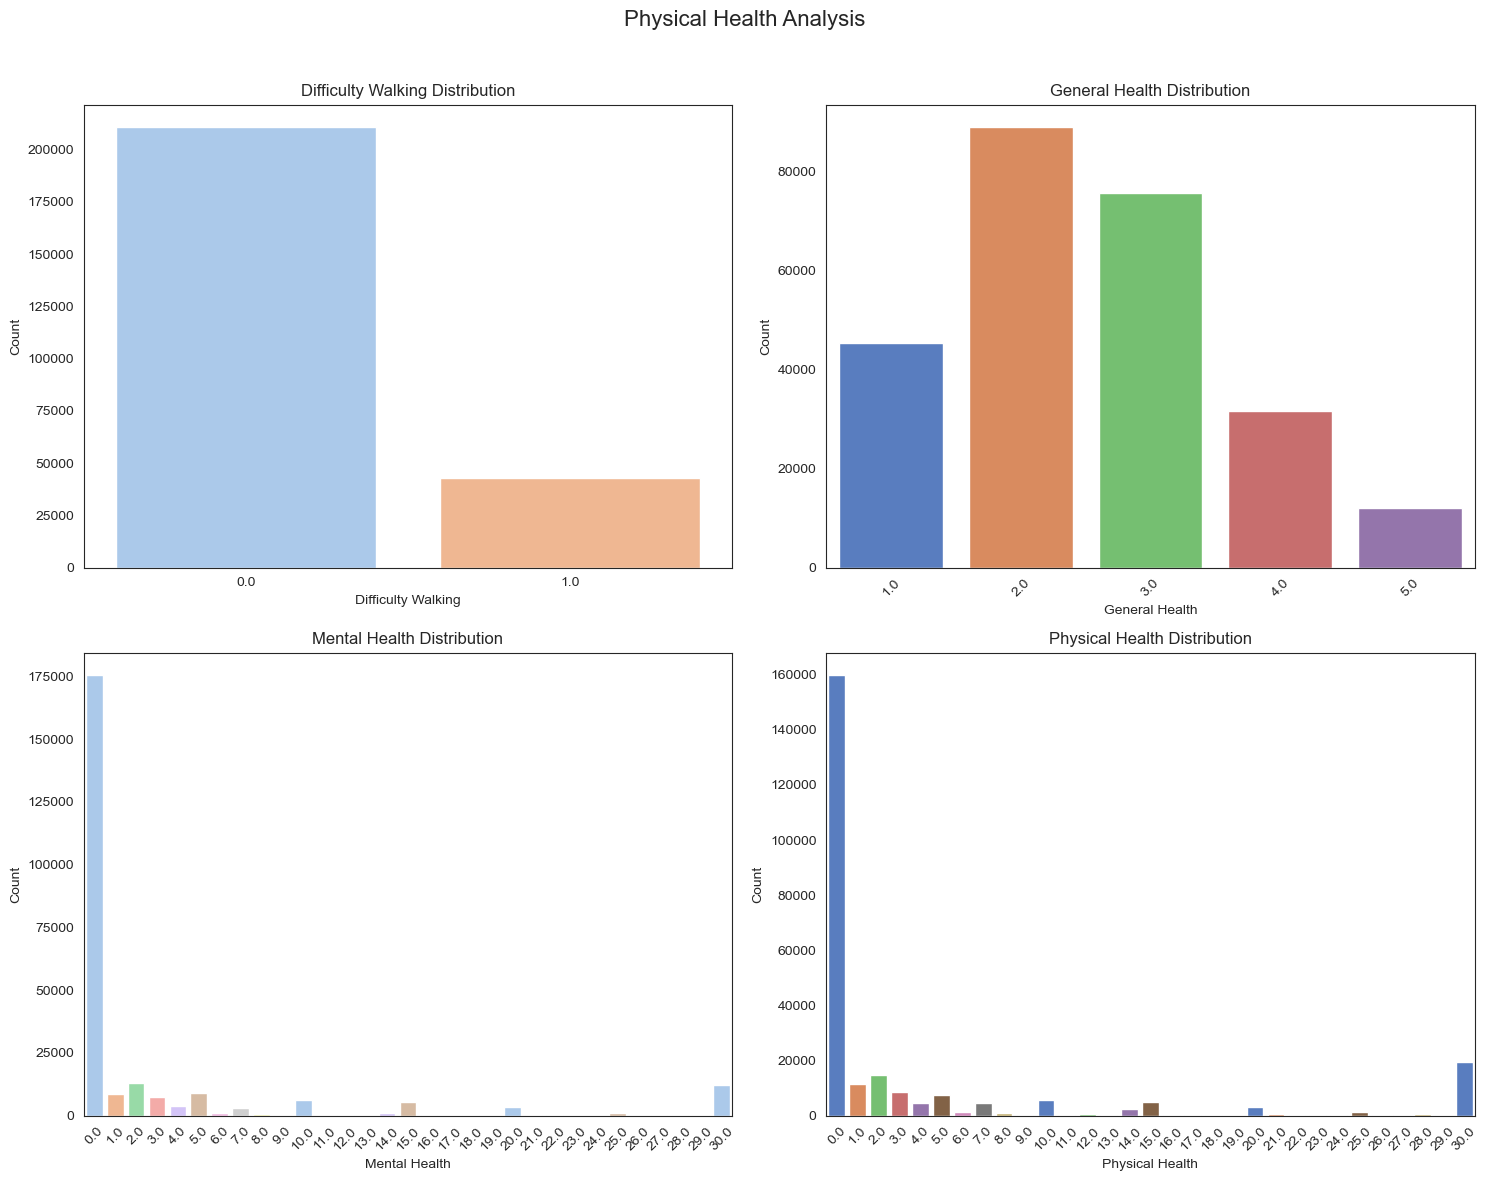

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'train_ds' is your DataFrame

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Physical Health Analysis', fontsize=16)

# Difficulty Walking (DiffWalk) Distribution
sns.countplot(x='DiffWalk', data=train_ds, palette='pastel', ax=axes[0, 0])
axes[0, 0].set_title('Difficulty Walking Distribution')
axes[0, 0].set_xlabel('Difficulty Walking')
axes[0, 0].set_ylabel('Count')

# General Health (GenHlth) Distribution
sns.countplot(x='GenHlth', data=train_ds, palette='muted', ax=axes[0, 1])
axes[0, 1].set_title('General Health Distribution')
axes[0, 1].set_xlabel('General Health')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Mental Health (MentHlth) Distribution
sns.countplot(x='MentHlth', data=train_ds, palette='pastel', ax=axes[1, 0])
axes[1, 0].set_title('Mental Health Distribution')
axes[1, 0].set_xlabel('Mental Health')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Physical Health (PhysHlth) Distribution
sns.countplot(x='PhysHlth', data=train_ds, palette='muted', ax=axes[1, 1])
axes[1, 1].set_title('Physical Health Distribution')
axes[1, 1].set_xlabel('Physical Health')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)
# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



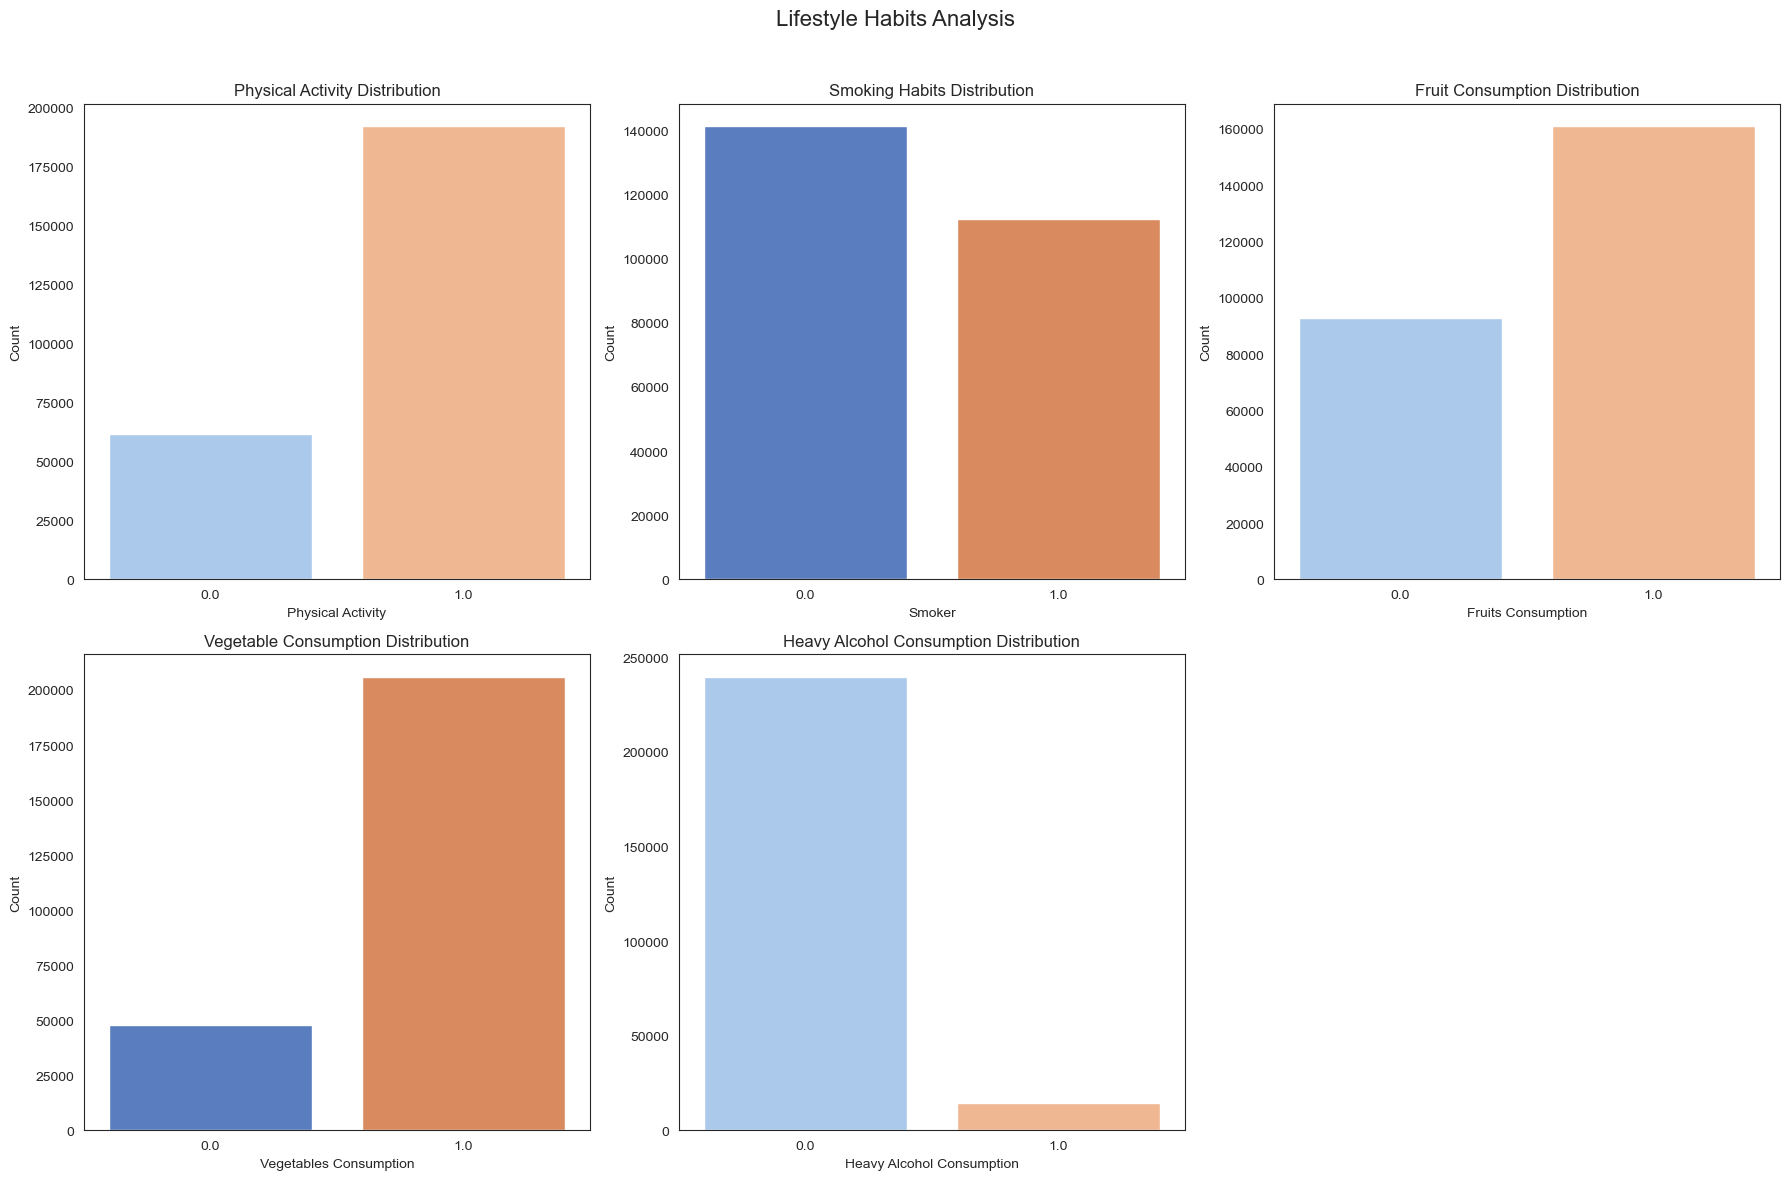

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'train_ds' is your DataFrame

# Set up subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Lifestyle Habits Analysis', fontsize=16)

# Physical Activity (PhysActivity) Distribution
sns.countplot(x='PhysActivity', data=train_ds, palette='pastel', ax=axes[0, 0])
axes[0, 0].set_title('Physical Activity Distribution')
axes[0, 0].set_xlabel('Physical Activity')
axes[0, 0].set_ylabel('Count')

# Smoking Habits (Smoker) Distribution
sns.countplot(x='Smoker', data=train_ds, palette='muted', ax=axes[0, 1])
axes[0, 1].set_title('Smoking Habits Distribution')
axes[0, 1].set_xlabel('Smoker')
axes[0, 1].set_ylabel('Count')

# Fruit Consumption (Fruits) Distribution
sns.countplot(x='Fruits', data=train_ds, palette='pastel', ax=axes[0, 2])
axes[0, 2].set_title('Fruit Consumption Distribution')
axes[0, 2].set_xlabel('Fruits Consumption')
axes[0, 2].set_ylabel('Count')

# Vegetable Consumption (Veggies) Distribution
sns.countplot(x='Veggies', data=train_ds, palette='muted', ax=axes[1, 0])
axes[1, 0].set_title('Vegetable Consumption Distribution')
axes[1, 0].set_xlabel('Vegetables Consumption')
axes[1, 0].set_ylabel('Count')

# Heavy Alcohol Consumption (HvyAlcoholConsump) Distribution
sns.countplot(x='HvyAlcoholConsump', data=train_ds, palette='pastel', ax=axes[1, 1])
axes[1, 1].set_title('Heavy Alcohol Consumption Distribution')
axes[1, 1].set_xlabel('Heavy Alcohol Consumption')
axes[1, 1].set_ylabel('Count')

# Add an empty subplot in the last position to balance the layout
fig.delaxes(axes[1, 2])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same e

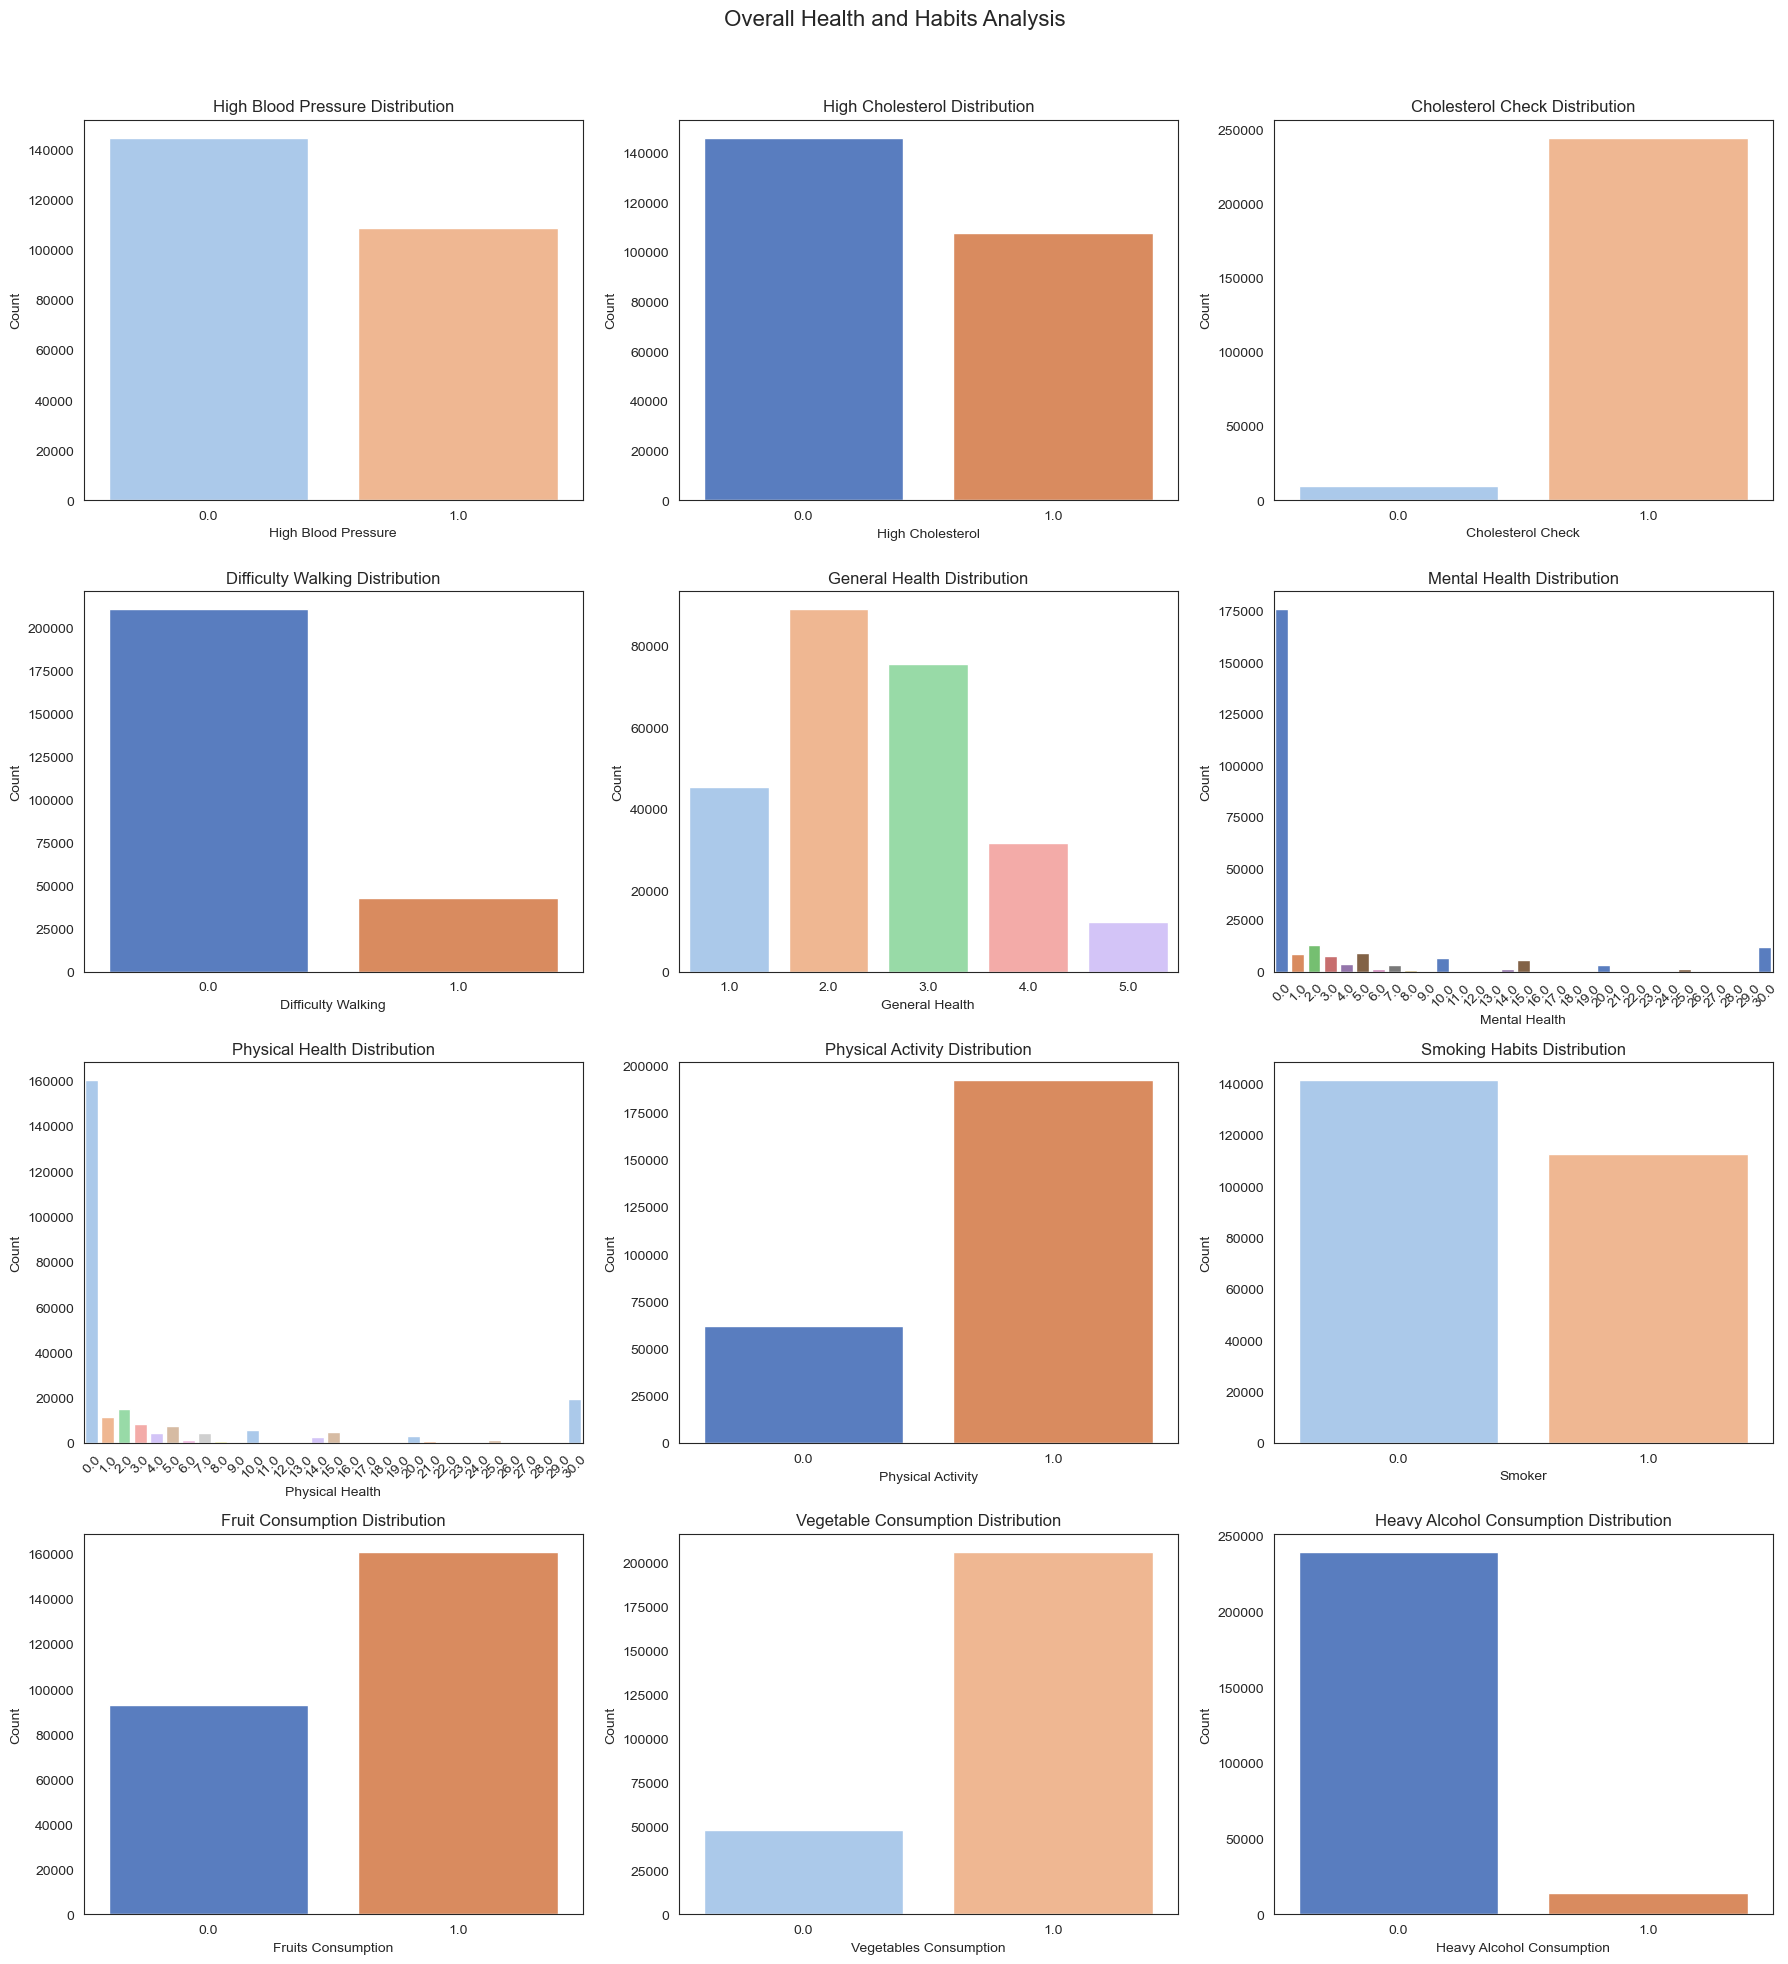

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'train_ds' is your DataFrame containing the overall health and habits data

# Set up subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Overall Health and Habits Analysis', fontsize=16)

# High Blood Pressure (HighBP) Distribution
sns.countplot(x='HighBP', data=train_ds, palette='pastel', ax=axes[0, 0])
axes[0, 0].set_title('High Blood Pressure Distribution')
axes[0, 0].set_xlabel('High Blood Pressure')
axes[0, 0].set_ylabel('Count')

# High Cholesterol (HighChol) Distribution
sns.countplot(x='HighChol', data=train_ds, palette='muted', ax=axes[0, 1])
axes[0, 1].set_title('High Cholesterol Distribution')
axes[0, 1].set_xlabel('High Cholesterol')
axes[0, 1].set_ylabel('Count')

# Cholesterol Check (CholCheck) Distribution
sns.countplot(x='CholCheck', data=train_ds, palette='pastel', ax=axes[0, 2])
axes[0, 2].set_title('Cholesterol Check Distribution')
axes[0, 2].set_xlabel('Cholesterol Check')
axes[0, 2].set_ylabel('Count')

# Difficulty Walking (DiffWalk) Distribution
sns.countplot(x='DiffWalk', data=train_ds, palette='muted', ax=axes[1, 0])
axes[1, 0].set_title('Difficulty Walking Distribution')
axes[1, 0].set_xlabel('Difficulty Walking')
axes[1, 0].set_ylabel('Count')

# General Health (GenHlth) Distribution
sns.countplot(x='GenHlth', data=train_ds, palette='pastel', ax=axes[1, 1])
axes[1, 1].set_title('General Health Distribution')
axes[1, 1].set_xlabel('General Health')
axes[1, 1].set_ylabel('Count')

# Mental Health (MentHlth) Distribution with rotated x-axis ticks
sns.countplot(x='MentHlth', data=train_ds, palette='muted', ax=axes[1, 2])
axes[1, 2].set_title('Mental Health Distribution')
axes[1, 2].set_xlabel('Mental Health')
axes[1, 2].set_ylabel('Count')
axes[1, 2].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks by 45 degrees

# Physical Health (PhysHlth) Distribution with rotated x-axis ticks
sns.countplot(x='PhysHlth', data=train_ds, palette='pastel', ax=axes[2, 0])
axes[2, 0].set_title('Physical Health Distribution')
axes[2, 0].set_xlabel('Physical Health')
axes[2, 0].set_ylabel('Count')
axes[2, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks by 45 degrees

# Physical Activity (PhysActivity) Distribution
sns.countplot(x='PhysActivity', data=train_ds, palette='muted', ax=axes[2, 1])
axes[2, 1].set_title('Physical Activity Distribution')
axes[2, 1].set_xlabel('Physical Activity')
axes[2, 1].set_ylabel('Count')

# Smoking Habits (Smoker) Distribution
sns.countplot(x='Smoker', data=train_ds, palette='pastel', ax=axes[2, 2])
axes[2, 2].set_title('Smoking Habits Distribution')
axes[2, 2].set_xlabel('Smoker')
axes[2, 2].set_ylabel('Count')

# Fruit Consumption (Fruits) Distribution
sns.countplot(x='Fruits', data=train_ds, palette='muted', ax=axes[3, 0])
axes[3, 0].set_title('Fruit Consumption Distribution')
axes[3, 0].set_xlabel('Fruits Consumption')
axes[3, 0].set_ylabel('Count')

# Vegetable Consumption (Veggies) Distribution
sns.countplot(x='Veggies', data=train_ds, palette='pastel', ax=axes[3, 1])
axes[3, 1].set_title('Vegetable Consumption Distribution')
axes[3, 1].set_xlabel('Vegetables Consumption')
axes[3, 1].set_ylabel('Count')

# Heavy Alcohol Consumption (HvyAlcoholConsump) Distribution
sns.countplot(x='HvyAlcoholConsump', data=train_ds, palette='muted', ax=axes[3, 2])
axes[3, 2].set_title('Heavy Alcohol Consumption Distribution')
axes[3, 2].set_xlabel('Heavy Alcohol Consumption')
axes[3, 2].set_ylabel('Count')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Numerical Variable

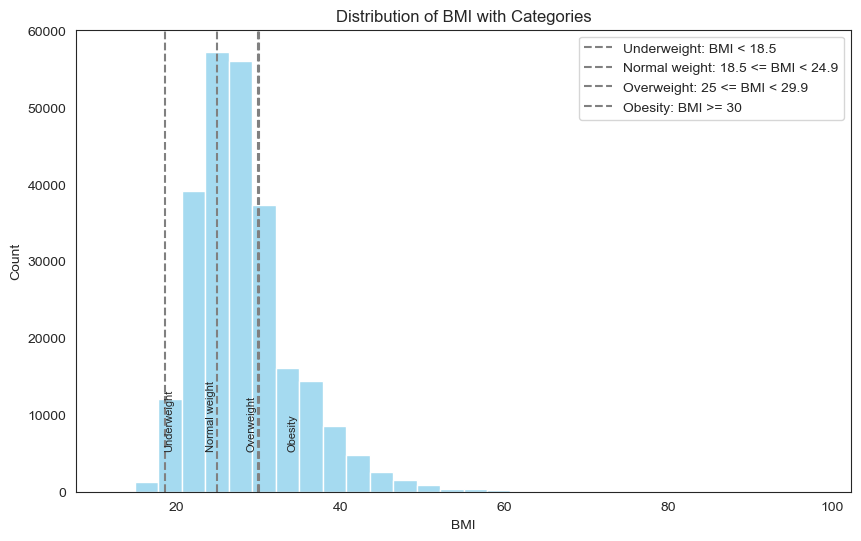

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define BMI categories
bmi_categories = ['Underweight', 'Normal weight', 'Overweight', 'Obesity']

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the histogram
sns.histplot(train_ds['BMI'], kde=False, bins=30, color='skyblue')

# Add vertical lines and text for BMI categories
plt.axvline(18.5, color='gray', linestyle='--', label='Underweight: BMI < 18.5')
plt.axvline(24.9, color='gray', linestyle='--', label='Normal weight: 18.5 <= BMI < 24.9')
plt.axvline(29.9, color='gray', linestyle='--', label='Overweight: 25 <= BMI < 29.9')
plt.axvline(30, color='gray', linestyle='--', label='Obesity: BMI >= 30')

# Add text labels
for i, category in enumerate(bmi_categories):
    plt.text(18.5 + i * 5, 5500, category, rotation=90, size=8)

# Set plot title and show the plot
plt.title('Distribution of BMI with Categories')
plt.legend()
plt.show()


## Lets find correlation

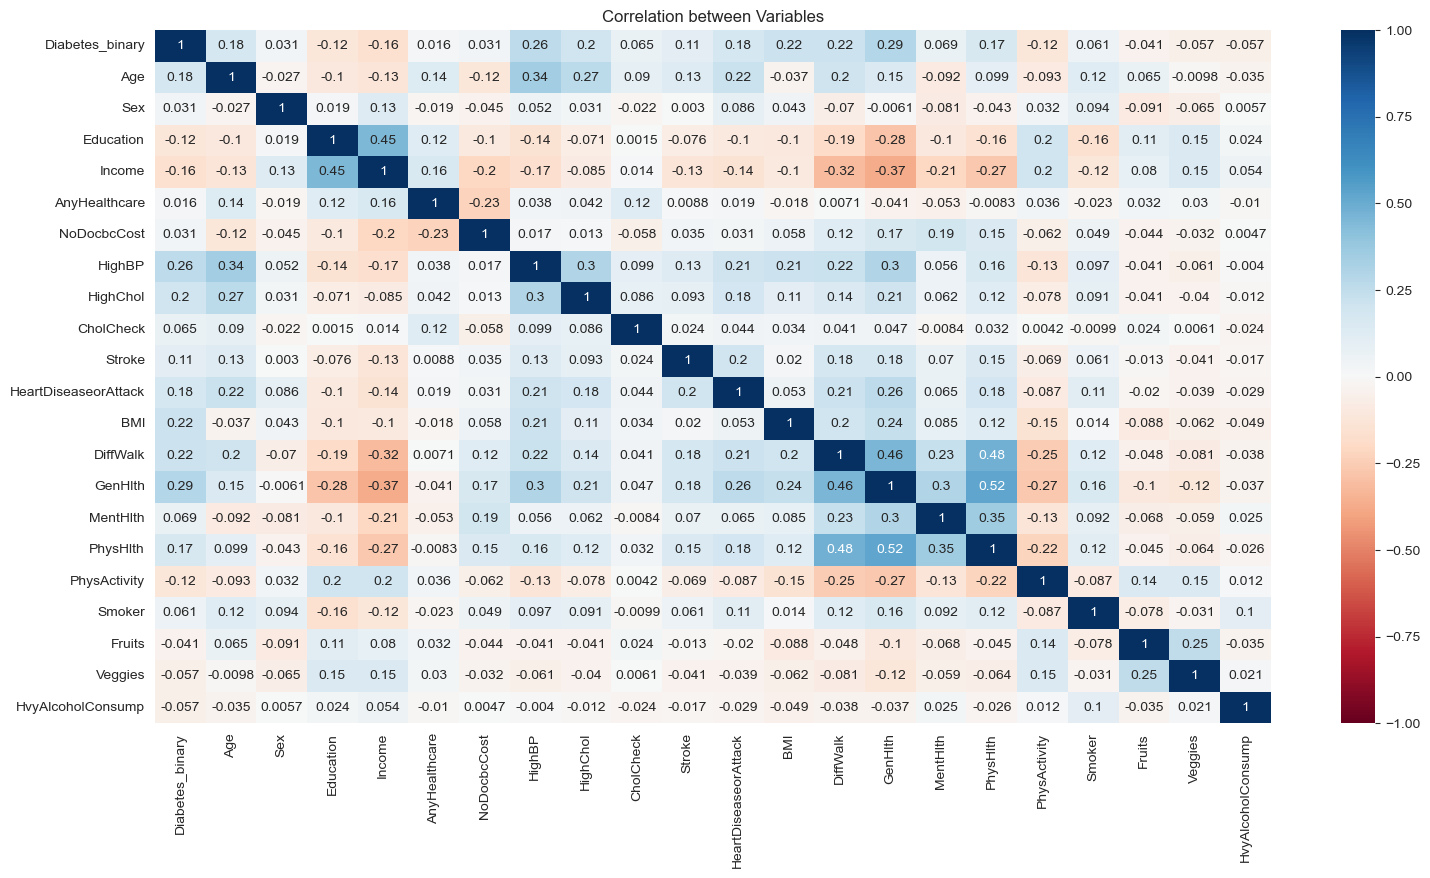

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the column order for better grouping and interpretation
cols = ['Diabetes_binary'] + demographics + healthcare_access + cardiovascular_health + ['BMI'] + physical_health + lifestyle_habits

'''
demographics = ['Age', 'Sex', 'Education', 'Income']

# Healthcare Access
healthcare_access = ['AnyHealthcare', 'NoDocbcCost']

# Cardiovascular Health
cardiovascular_health = ['HighBP', 'HighChol', 'CholCheck', 'Stroke', 'HeartDiseaseorAttack']

# Physical Health
physical_health = ['DiffWalk', 'GenHlth', 'MentHlth', 'PhysHlth']

# Lifestyle Habits
lifestyle_habits = ['PhysActivity', 'Smoker', 'Fruits', 'Veggies', 'HvyAlcoholConsump']
'''

# Create a heatmap to check the correlation between the variables
plt.figure(figsize=(18, 9))
correlation_matrix = train_ds[cols].corr()

# Set up the heatmap with annotations and a color scale
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmin=-1, vmax=1)

# Set plot title
plt.title('Correlation between Variables')

# Show the plot
plt.show()


In [32]:
train_ds.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [33]:
# Calculate the absolute correlation of each variable with the target variable
correlation_with_target = train_ds.corr()['Diabetes_binary'].abs()

# Sort the variables in descending order and select the top 15
top_correlated_variables = correlation_with_target.sort_values(ascending=False).head(15)

# Display the result
print(top_correlated_variables)


Diabetes_binary         1.000000
GenHlth                 0.293569
HighBP                  0.263129
DiffWalk                0.218344
BMI                     0.216843
HighChol                0.200276
Age                     0.177442
HeartDiseaseorAttack    0.177282
PhysHlth                0.171337
Income                  0.163919
Education               0.124456
PhysActivity            0.118133
Stroke                  0.105816
MentHlth                0.069315
CholCheck               0.064761
Name: Diabetes_binary, dtype: float64


# MODEL FITTING

In [34]:
!pip install ucimlrepo

In [35]:
!pip install prettytable


In [12]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)


{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [13]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from prettytable import PrettyTable

In [14]:
X.shape, y.shape

((253680, 21), (253680, 1))

In [15]:
y.value_counts()

Diabetes_binary
0                  218334
1                   35346
Name: count, dtype: int64

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [17]:
X_train

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
1956,0,1,1,25,1,0,0,0,0,1,...,1,0,2,4,0,0,0,7,4,8
49982,1,0,1,35,0,0,0,1,1,1,...,1,0,2,0,0,0,0,5,5,8
229678,0,1,1,29,1,0,0,0,1,0,...,1,0,3,0,0,0,1,9,5,8
35542,0,0,1,37,1,0,0,1,1,1,...,1,0,2,30,5,0,0,4,4,5
155236,1,1,1,23,1,0,0,1,1,1,...,1,0,1,0,0,0,0,12,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,1,0,1,45,1,0,0,1,1,0,...,1,1,1,15,0,0,0,5,4,1
103694,1,1,1,29,1,0,0,1,0,1,...,1,0,3,0,0,0,1,11,6,7
131932,0,1,1,25,0,0,0,1,1,1,...,1,0,2,0,3,0,0,9,6,8
146867,0,0,0,23,0,0,0,0,1,1,...,1,1,2,0,0,0,0,5,6,6


In [18]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

In [19]:
y_train_smote.value_counts()

Diabetes_binary
0                  130900
1                  130900
Name: count, dtype: int64

In [20]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'k-NN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

In [50]:
result_table = PrettyTable()
result_table.field_names = ["Model", "Validation Accuracy", "Classification Report"]


In [59]:
import time
start_time = time.time()

trained_models = {}
for model_name, model in models.items():
    # Model Training
    model.fit(X_train_smote, y_train_smote)
    trained_models[model_name] = model

    filename = save_path + f'{model_name}_model2.pkl'
    joblib.dump(model, filename)

    # Model Prediction on Validation Set
    y_val_pred = model.predict(X_val)

    # Model Evaluation on Validation Set
    accuracy = accuracy_score(y_val, y_val_pred)
    report = classification_report(y_val, y_val_pred)

    # Add results to the table
    result_table.add_row([model_name, f"{accuracy:.4f}", report])

end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

# Print the table
print(result_table)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://

Execution time: 2584.015149831772 seconds
+---------------------+---------------------+-------------------------------------------------------+
|        Model        | Validation Accuracy |                 Classification Report                 |
+---------------------+---------------------+-------------------------------------------------------+
| Logistic Regression |        0.8601       |               precision    recall  f1-score   support |
|                     |                     |                                                       |
|                     |                     |            0       0.88      0.97      0.92     43645 |
|                     |                     |            1       0.50      0.16      0.25      7091 |
|                     |                     |                                                       |
|                     |                     |     accuracy                           0.86     50736 |
|                     |                 

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

# Feature importance

In [16]:
# rank1_model = models['SVM']
# rank2_model = models['Logistic Regression']
# rank3_model = models['k-NN']

In [21]:
model_path = 'DM_models/'

random_forest_model = joblib.load(model_path + 'Random Forest_model2.pkl')
SVM_model = joblib.load(model_path + 'SVM_model2.pkl')
DecisionTree_model = joblib.load(model_path + 'Decision Tree_model2.pkl')
LogisticRegression_model = joblib.load(model_path + 'Logistic Regression_model2.pkl')
KNN_model = joblib.load(model_path + 'k-NN_model2.pkl')

In [22]:
# # plot the feature importance
# feature_importance = pd.DataFrame({'feature': X.columns,
#                                    'importance': random_forest_model.feature_importances_})
# feature_importance.sort_values(by='importance', ascending=False, inplace=True)

# plt.figure(figsize=(10, 6))
# sns.barplot(x='importance', y='feature', data=feature_importance)
# plt.title('Feature importance of having diabetes')
# plt.show()


In [23]:
loaded_dic = {'Logistic Regression': LogisticRegression_model,
    'Decision Tree': DecisionTree_model,
    'Random Forest': random_forest_model,
    'SVM': SVM_model,
    'k-NN': KNN_model,
    }

Feature Importance for Logistic Regression


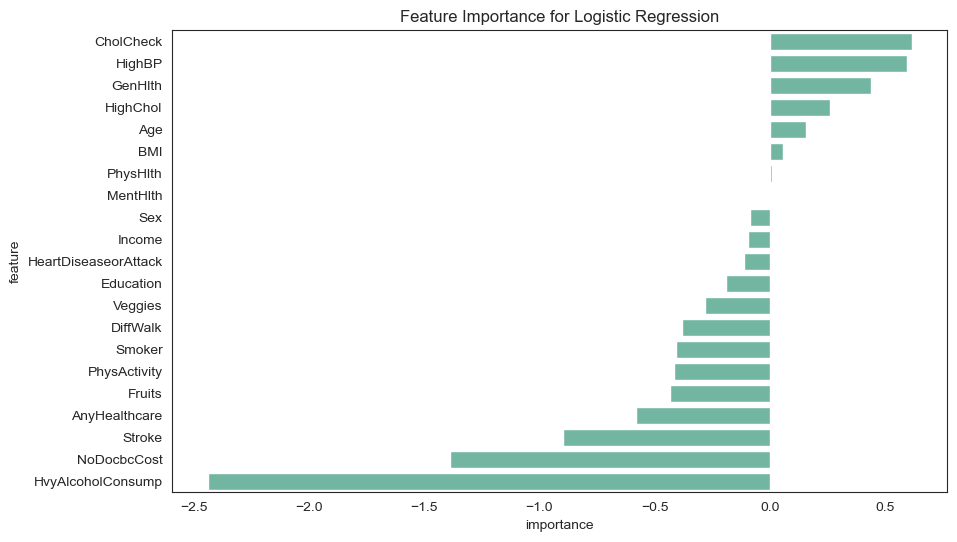

Feature Importance for Decision Tree


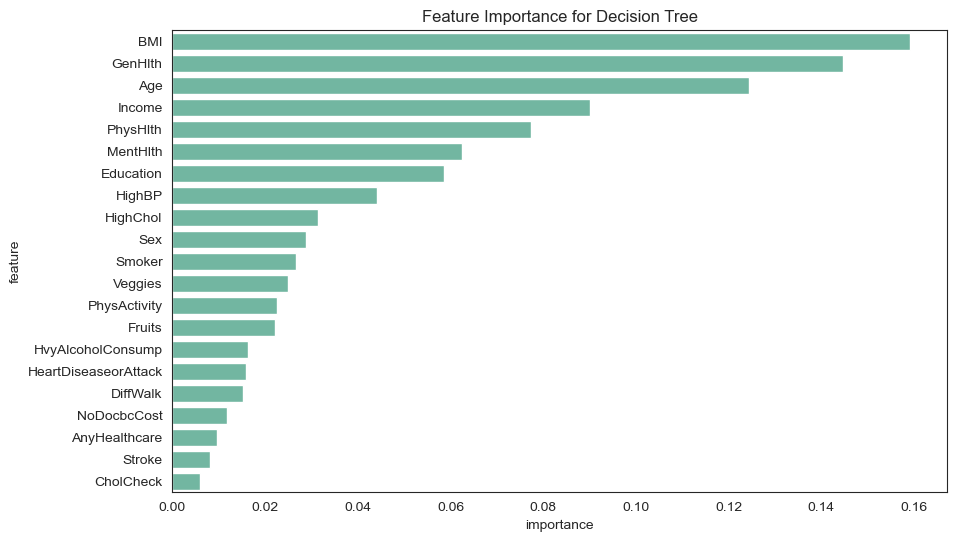

Feature Importance for Random Forest


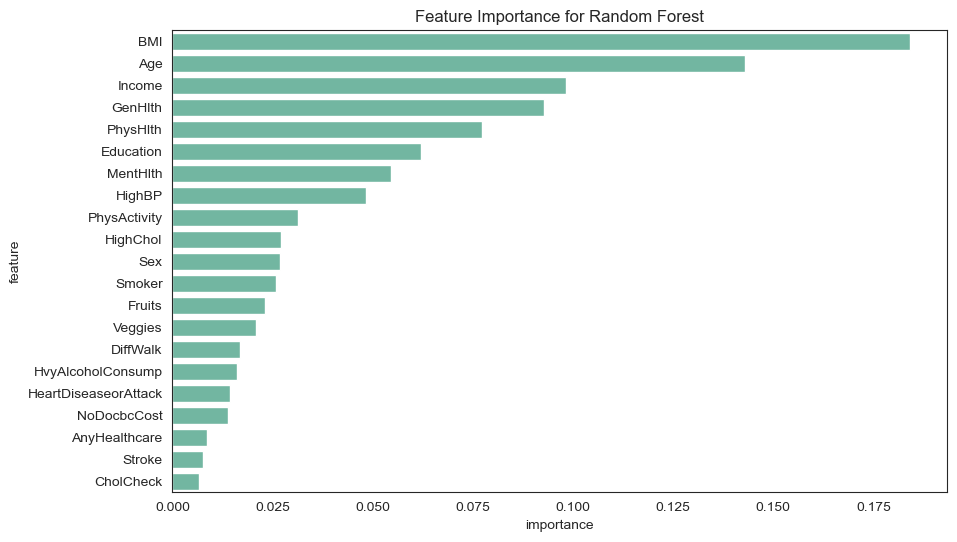

Feature Importance for SVM
Feature importance not available or not applicable for SVM
Feature Importance for k-NN
Feature importance not available or not applicable for k-NN


In [24]:

for model_name, model in loaded_dic.items():
    print(f"Feature Importance for {model_name}")

    if hasattr(model, 'feature_importances_'):  # Tree-based models
        feature_importance = pd.DataFrame({'feature': X_train.columns,
                                           'importance': model.feature_importances_})
    elif hasattr(model, 'coef_') and len(model.coef_) > 0:  # Linear models like Logistic Regression
        feature_importance = pd.DataFrame({'feature': X_train.columns,
                                           'importance': model.coef_[0]})
    else:
        print(f"Feature importance not available or not applicable for {model_name}")
        continue

    feature_importance.sort_values(by='importance', ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title(f'Feature Importance for {model_name}')
    plt.show()


In [26]:
X_test.size

1065456

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/atharvagurav/Documents/Data Mining/Sample_proj1/env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/atharvagurav/Documents/Data Mining/Sample_proj1/env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/atharvagurav/Documents/Data Mining/Sample_proj1/env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/atharvagurav/Documents/Data Mining/Sample_proj1/env/lib/python3.11/s

Execution time: 93.26579928398132 seconds


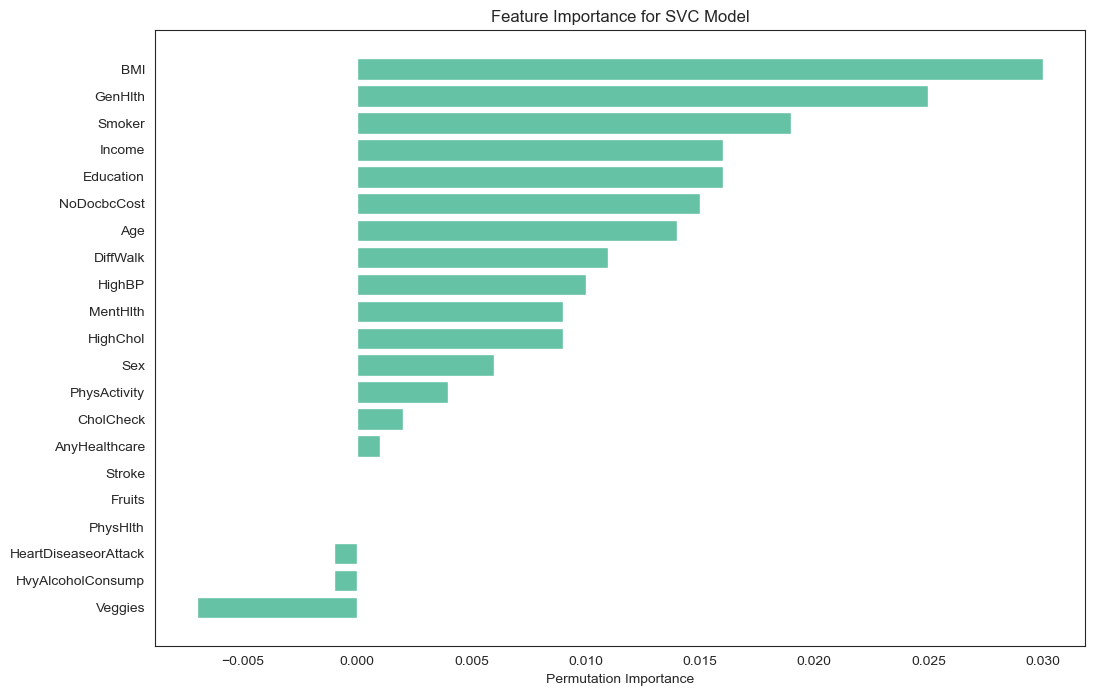

In [25]:
from sklearn.inspection import permutation_importance
import warnings
start_time = time.time()
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore',category=FutureWarning, module="sklearn")


# X_test and y_test are your test datasets
svc_model = loaded_dic['SVM']

# Reduce the sample size for the permutation importance calculation
# Adjust the sample size according to your dataset size and available computational resources
sample_size = 200  # for example, 200 instances
X_sample = shap.sample(X_test, sample_size)
y_sample = y_test.iloc[:sample_size]

# Calculate permutation importance with reduced repeats and parallel processing
result = permutation_importance(svc_model, X_sample, y_sample, n_repeats=5, random_state=42, n_jobs=-1)

# Sort features by importance
sorted_idx = result.importances_mean.argsort()
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

# Plot the results
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_test.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance for SVC Model")
plt.show()


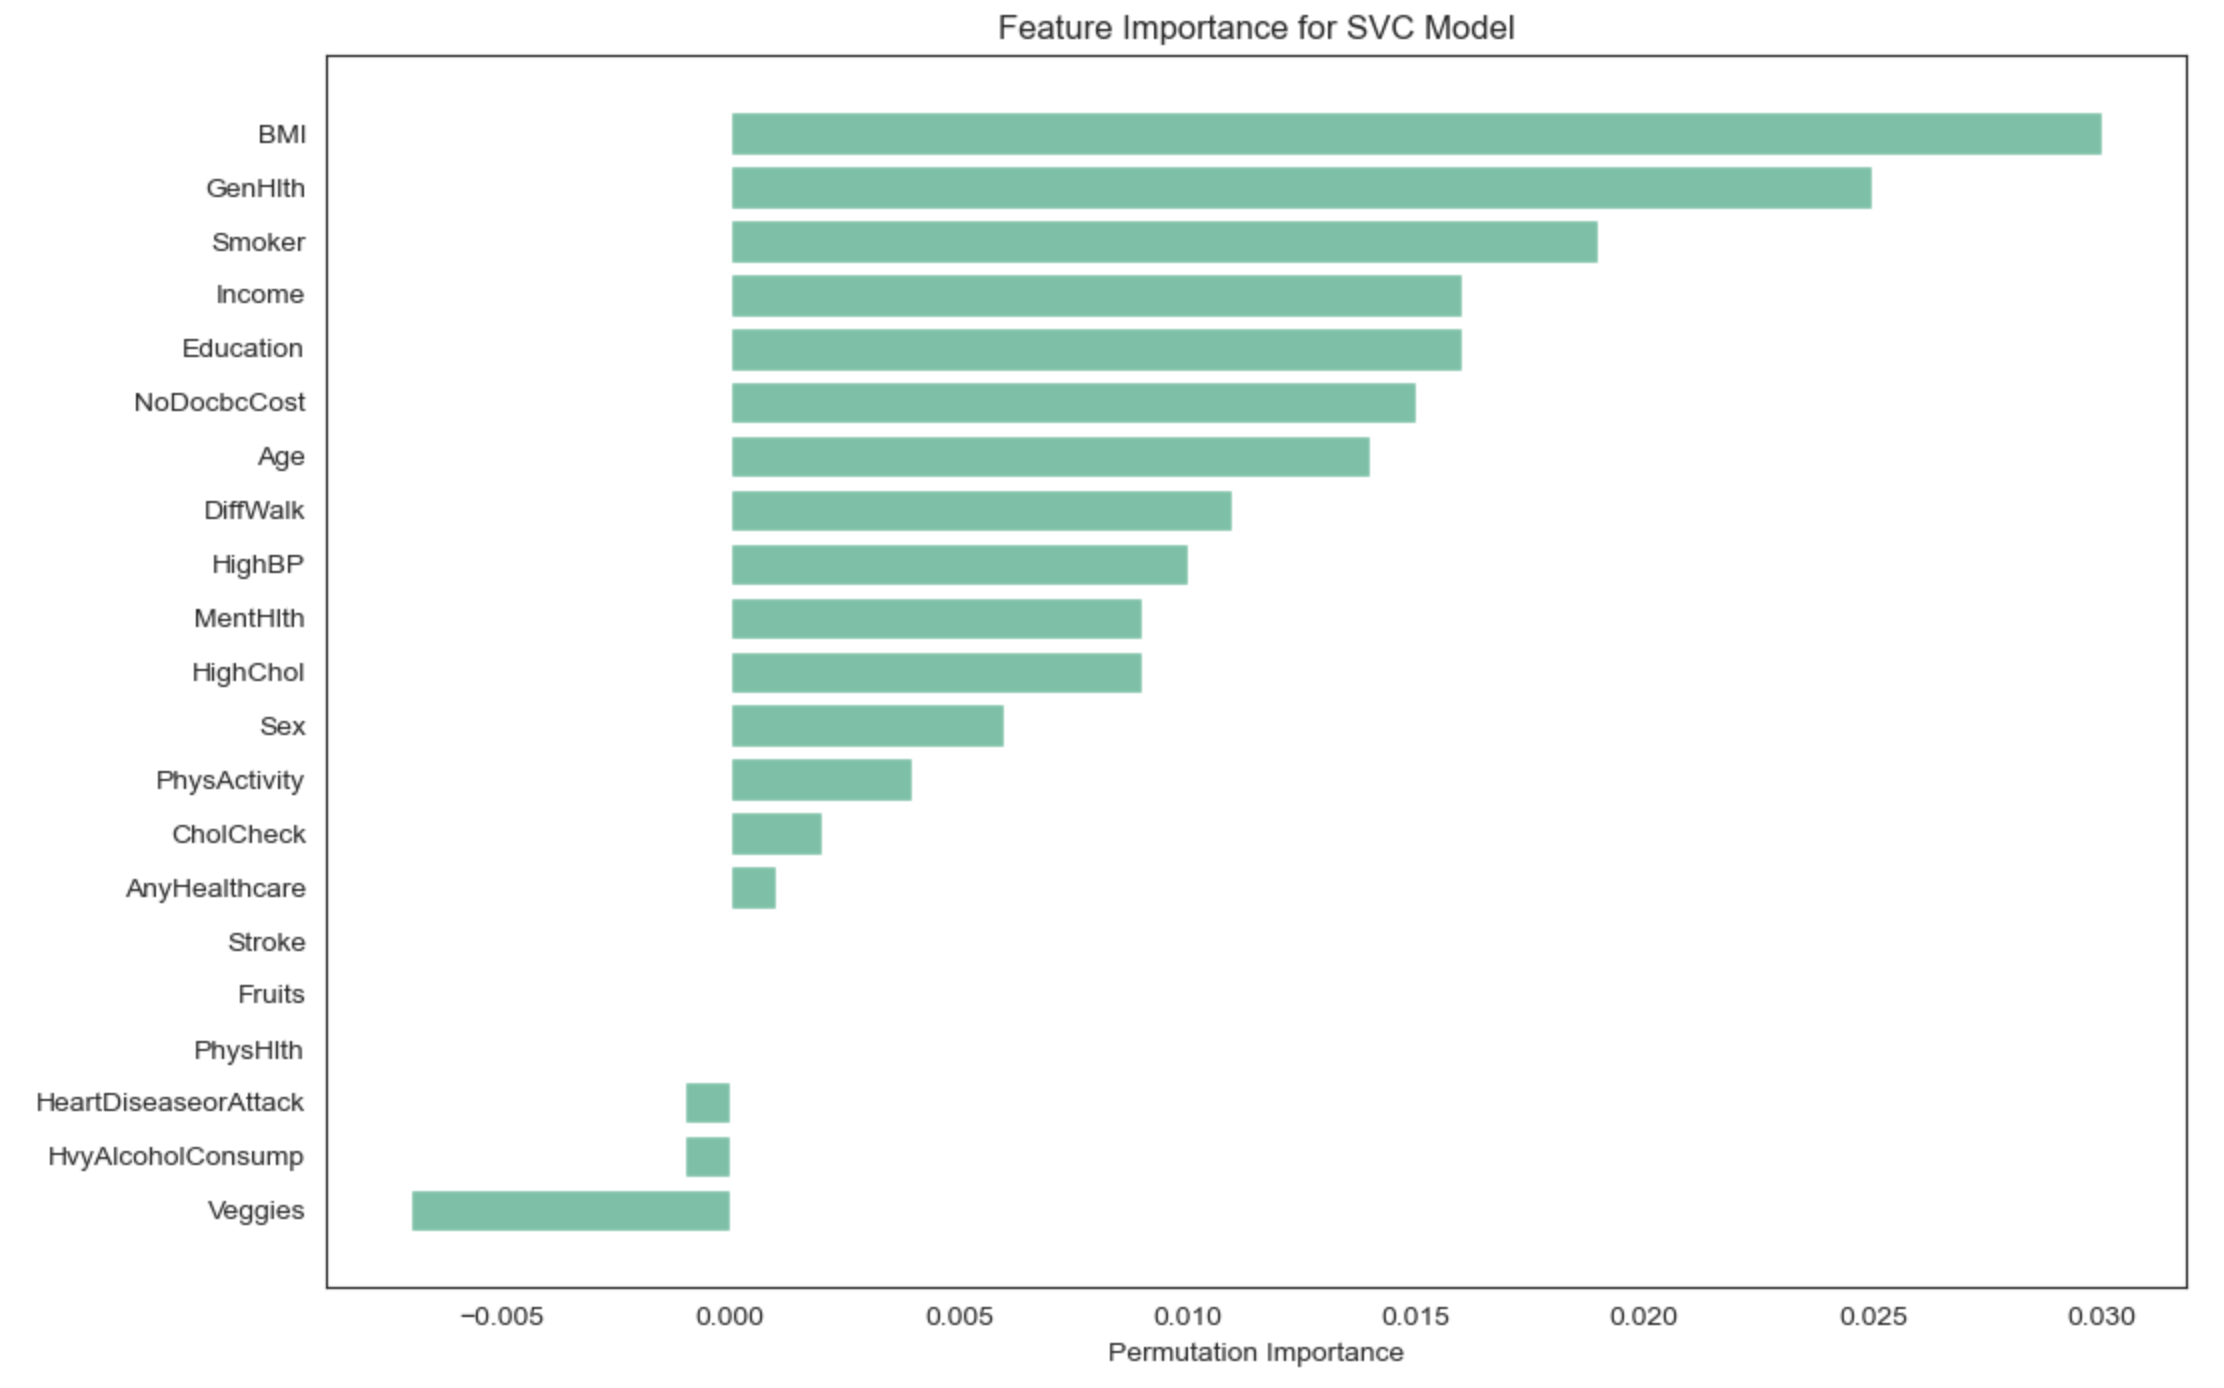

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/atharvagurav/Documents/Data Mining/Sample_proj1/env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/atharvagurav/Documents/Data Mining/Sample_proj1/env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/atharvagurav/Documents/Data Mining/Sample_proj1/env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/atharvagurav/Documents/Data Mining/Sample_proj1/env/lib/python3.11/s

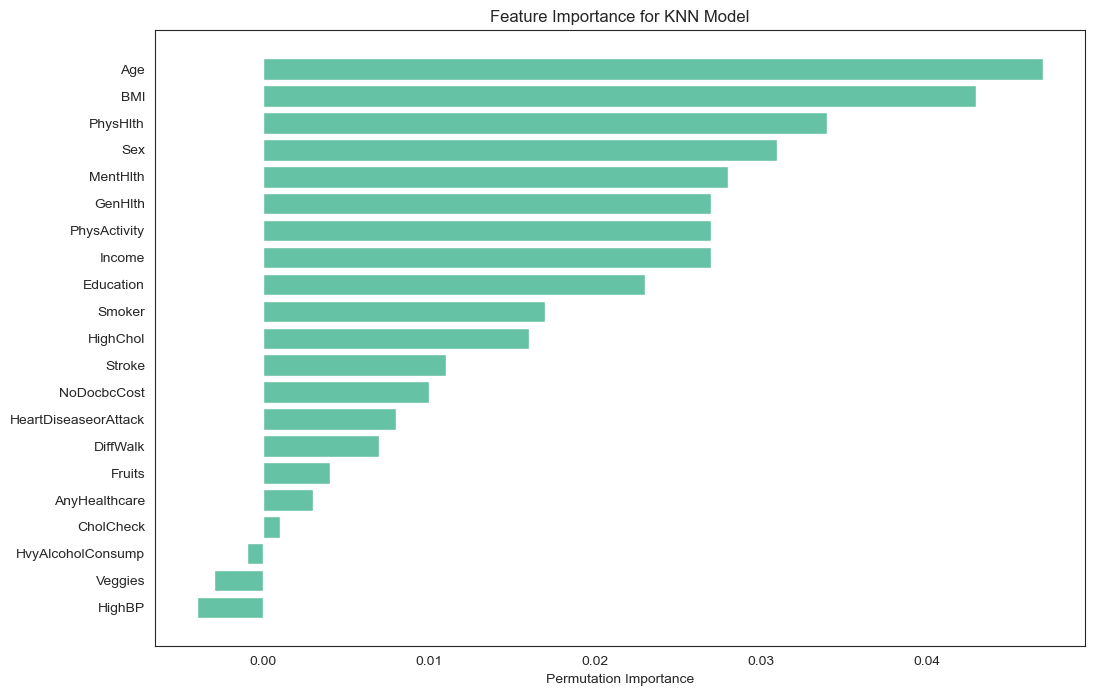

In [26]:
from sklearn.inspection import permutation_importance
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore',category=FutureWarning, module="sklearn")

# X_test and y_test are your test datasets
knn_model = loaded_dic['k-NN']

# Reduce the sample size for the permutation importance calculation
# Adjust the sample size according to your dataset size and available computational resources
sample_size = 200  # for example, 10000 instances
X_sample = shap.sample(X_test, sample_size)
y_sample = y_test.iloc[:sample_size]

# Calculate permutation importance with reduced repeats and parallel processing
result = permutation_importance(knn_model, X_sample, y_sample, n_repeats=5, random_state=42, n_jobs=-1)

# Sort features by importance
sorted_idx = result.importances_mean.argsort()

# Plot the results
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_test.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance for KNN Model")
plt.show()


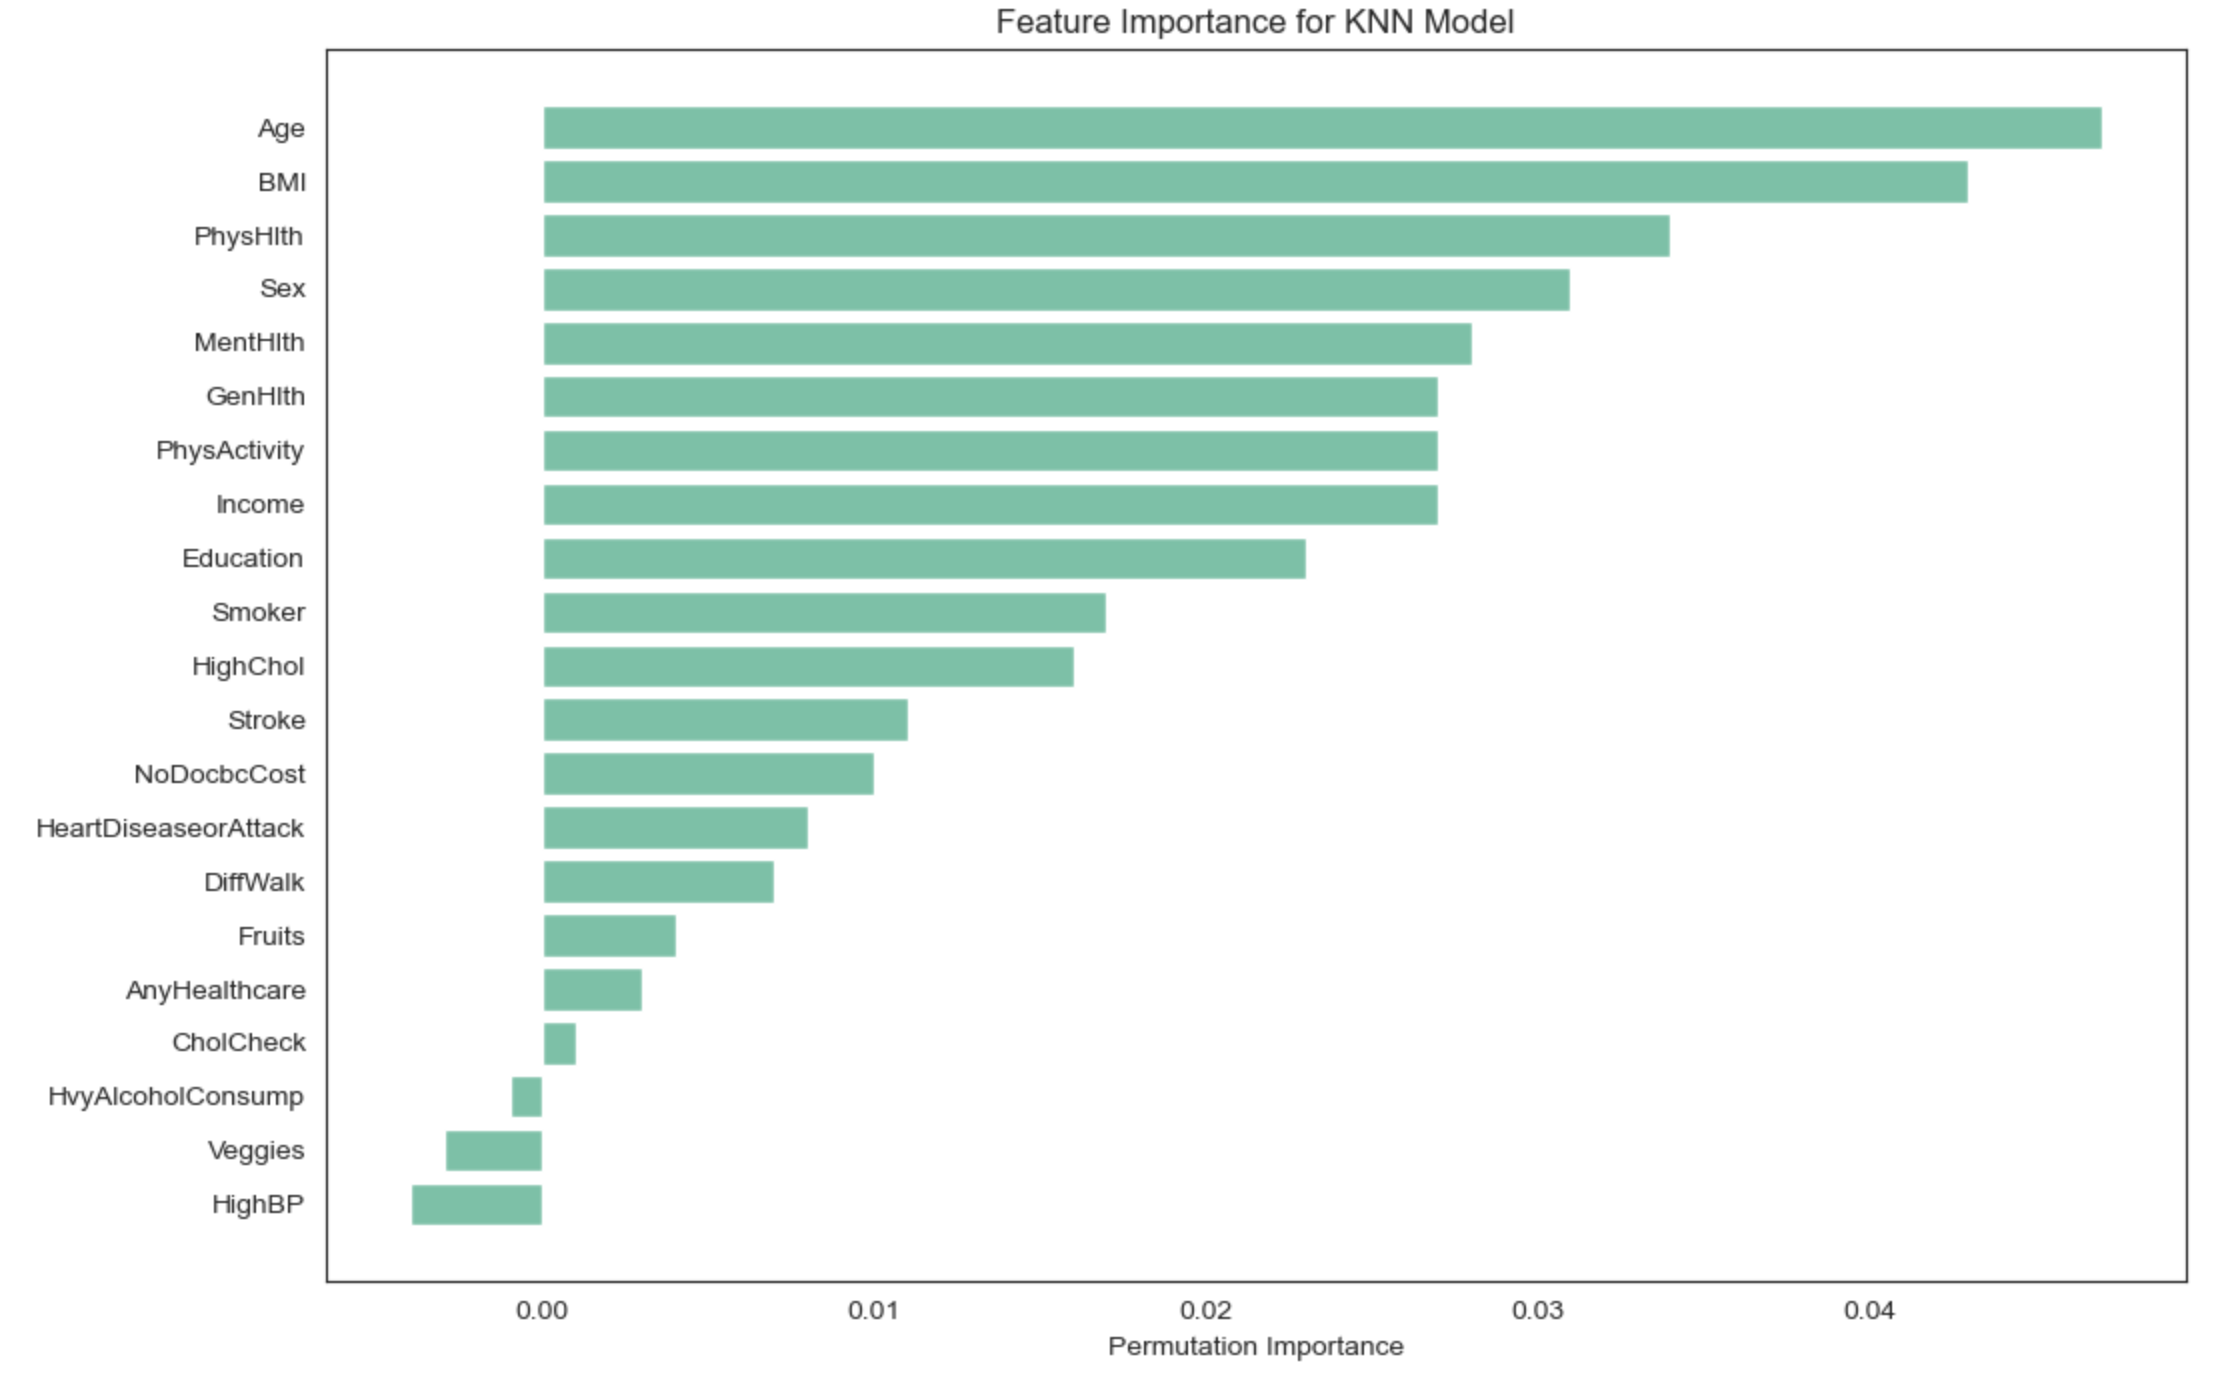

In [ ]:
# the total importance of the top 8 features
feature_importance.head(8)['importance'].sum()

0.7346825858176168

We can find that feature importance analysis results are roughly consistent with the correlation results.

In [ ]:

# # svc_model = loaded_dic['SVM']
# SVM_model = loaded_dic['SVM']
# # Because KernelExplainer can be slow, we use a subset of data (e.g., 100 instances)
# X_sample = shap.sample(X_train, 100)

# # Create a SHAP explainer object
# explainer = shap.KernelExplainer(SVM_model.predict, X_sample, n_jobs=-1)

# # Compute SHAP values 
# shap_values = explainer.shap_values(X_sample)


  0%|          | 0/100 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Predict test data

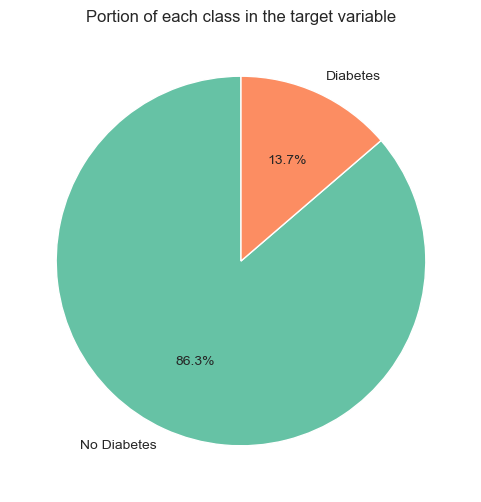

In [28]:
# we have to remember that the data is imbalanced

# plot the portion of each class in the target variable as pie chart
plt.figure(figsize=(6, 6))
plt.pie(y_test.value_counts(), labels=['No Diabetes', 'Diabetes'], autopct='%1.1f%%', startangle=90)
plt.title('Portion of each class in the target variable')
plt.show()


## SVC

              precision    recall  f1-score   support

           0       0.95      0.70      0.81     43789
           1       0.28      0.75      0.41      6947

    accuracy                           0.71     50736
   macro avg       0.62      0.73      0.61     50736
weighted avg       0.86      0.71      0.75     50736

ROC AUC score: 0.7256536715911732


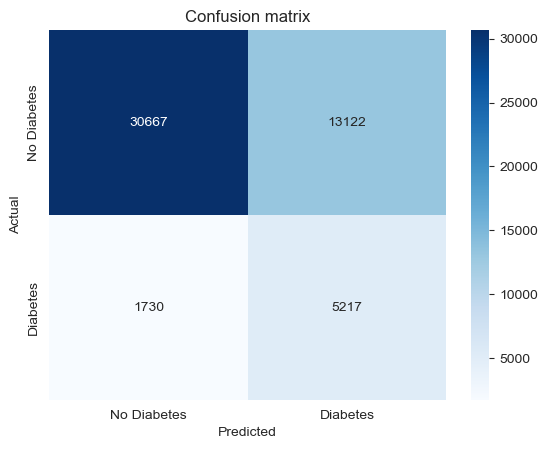

In [29]:
# predict the test set
y_test_pred = SVM_model.predict(X_test)

# print the classification report
print(classification_report(y_test, y_test_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_test_pred)}')

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['No Diabetes', 'Diabetes'])
plt.yticks([0.5, 1.5], ['No Diabetes', 'Diabetes'])
plt.title('Confusion matrix')
plt.show()

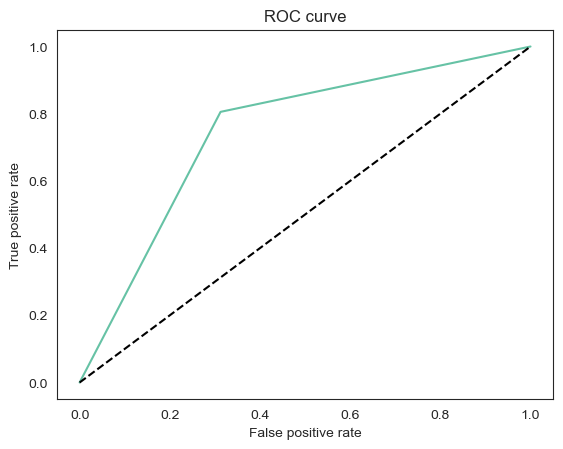

In [49]:
# plot the ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()


# For KNN

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     43789
           1       0.28      0.78      0.42      6947

    accuracy                           0.70     50736
   macro avg       0.62      0.73      0.61     50736
weighted avg       0.86      0.70      0.75     50736

ROC AUC score: 0.7325578084362399


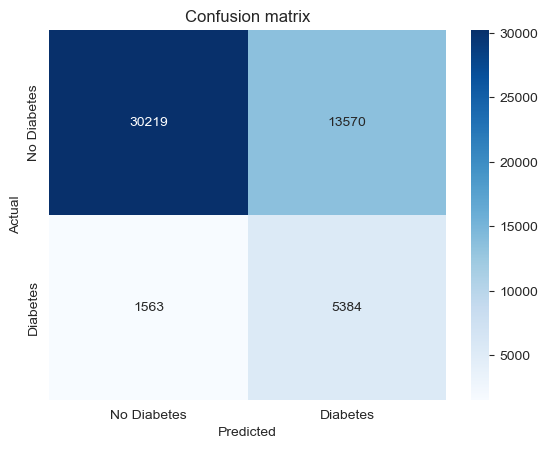

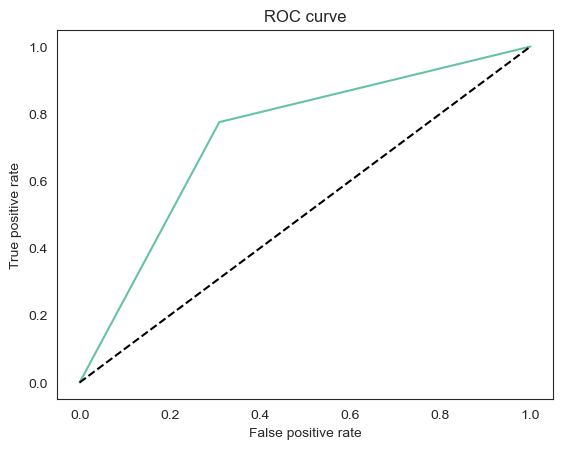

In [50]:
# predict the test set
y_test_pred2 = KNN_model.predict(X_test)

# print the classification report
print(classification_report(y_test, y_test_pred2))
print(f'ROC AUC score: {roc_auc_score(y_test, y_test_pred2)}')

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['No Diabetes', 'Diabetes'])
plt.yticks([0.5, 1.5], ['No Diabetes', 'Diabetes'])
plt.title('Confusion matrix')
plt.show()



# plot the ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred2)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()
